# **Ejercicio 2**

## **Librerías y modulos necesarios**

In [ ]:
import pandas as pd
#import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
#from rdkit import Chem
#from rdkit.Chem import Draw
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from IPython.display import display
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

# **Ejercicio 2.1: Predict New Medicines with BELKA**

# **Contextualización**

Los fármacos de moléculas pequeñas son compuestos químicos que interactúan con proteínas celulares para alterar sus funciones, generalmente inhibiendo proteínas implicadas en enfermedades. Tradicionalmente, la identificación de moléculas candidatas es un proceso largo y laborioso, ya que implica fabricarlas una por una y probar su interacción con proteínas específicas. Aunque la FDA ha aprobado alrededor de 2.000 nuevas moléculas, se estima que existen 10^60 productos químicos potenciales en el espacio farmacológico, lo que hace imposible buscarlos físicamente. Por ello, se necesitan métodos más eficientes para descubrir tratamientos escondidos en este vasto espacio químico.

<div style="text-align: center;">
    <img src="https://github.com/kmarcela11/Parcial1_MachineLearning/blob/main/Imagen.jpg?raw=true" alt= " " width="600"/>
</div>


## **Objetivos**

- Aplicar técnicas de machine learning para predecir si una molécula pequeña se unirá a proteínas específicas, utilizando modelos bien entrenados que permitan evitar experimentos de laboratorio costosos y lentos.
- Analizar diferentes tipos de moléculas para determinar si se adhieren o no a las proteínas objetivo, mejorando la comprensión de su interacción.
- Predecir si una molécula es aglutinante o no de una proteína, es decir, si la molécula se adhiere a las tres proteínas de interés que se están estudiando.

## **Datos importantes**

- Este proyecto selecciona tres proteínas diana clave: EPHX2 (sEH), BRD4, y ALB (HSA). EPHX2/sEH es una hidrolasa implicada en la hipertensión y la diabetes, que ha sido un objetivo farmacológico en ensayos clínicos. BRD4 es un bromodominio que afecta la transcripción genética y desempeña un papel en la progresión del cáncer, habiendo sido evaluado previamente para indicaciones oncológicas. ALB, también conocida como albúmina sérica humana, es la proteína más abundante en la sangre y juega un papel importante en la absorción y transporte de fármacos, siendo clave para mejorar la eficacia de los tratamientos farmacológicos.
- Los ejemplos en el conjunto de datos están representados por una clasificación binaria de si una molécula pequeña dada es un aglutinante o no de una de las tres proteínas objetivo.
- La química está representada por SMILES (Simplified Molecular-Input Line-Entry System) y las etiquetas como clasificaciones de unión binaria, una por proteína diana.
- Para este ejercicio, se cuenta con dos bases de datos: `train`y `test`.

## **Diccionario de variables**
| Variable              | Descripción                                                                                       |
|-----------------------|---------------------------------------------------------------------------------------------------|
|`id`                | Un example_id único que identifica el par de dianas de unión a la molécula.                        |
| `buildingblock1_smiles` | La estructura, en SMILES, del primer bloque de construcción.                                     |
| `buildingblock2_smiles` | La estructura, en SMILES, del segundo bloque de construcción.                                    |
| `buildingblock3_smiles` | La estructura, en SMILES, del tercer bloque de construcción.                                     |
| `molecule_smiles`    | La estructura completa de la molécula ensamblada, en SMILES. Esto incluye los tres bloques de construcción y el núcleo de triazina. Se usa 'a' como sustituto del enlazador de ADN. |
| `protein_name`       | El nombre de la proteína objetivo.                                                                 |
| `binds`              | La columna de destino. Una etiqueta de clase binaria que indica si la molécula se une a la proteína. No disponible en el conjunto de prueba. |


# **Base de datos (Entrenamiento)**

Inicialmente se hace el cargue del conjunto de datos de entrenamiento, con el uso de la librería `pandas` y el módulo **`read_parquet`** para leer el archivo en formato `Parquet`. El formato Parquet es usado para almacenar y comprimir grandes volúmenes de datos, optimizando  el uso del espacio.

En este caso, se utiliza el parámetro `engine = 'pyarrow'` que indica que se usará la biblioteca **PyArrow** como motor para la lectura del archivo Parquet. PyArrow es preferido por su velocidad y eficiencia al manejar grandes conjuntos de datos.


In [ ]:
data = pd.read_parquet('train.parquet', engine = 'pyarrow')

En esta parte, se busca visualizar las estructuras moleculares que componen los datos químicos utilizando el formato SMILES.


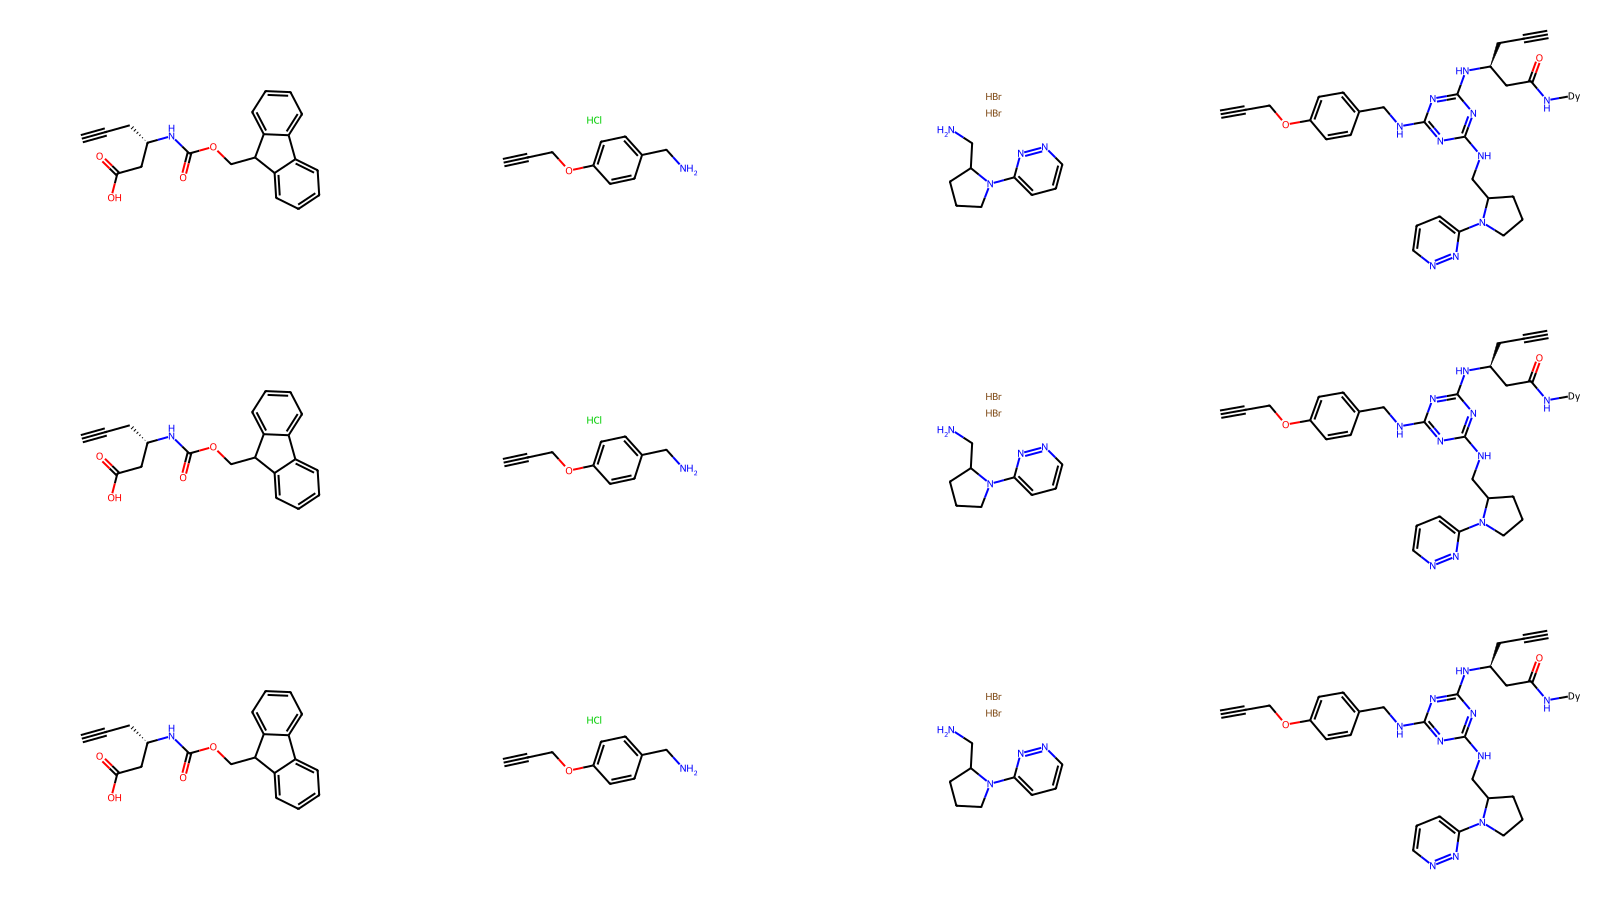

In [ ]:
# Visualización de algunas moléculas.
def moleculas(data, cantidad):
    data_mol = data.reset_index(drop = True)
    mols = []
    for i in range(cantidad):
        mols += [Chem.MolFromSmiles(data_mol['buildingblock1_smiles'][i]),Chem.MolFromSmiles(data_mol['buildingblock2_smiles'][i]),
                 Chem.MolFromSmiles(data_mol['buildingblock3_smiles'][i]),Chem.MolFromSmiles(data_mol['molecule_smiles'][i])]
    return Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(400,300))

moleculas(data, 3)

Al ver la imagen es posible observar cómo están conformadas las moléculas a partir de sus bloques de construcción individuales y la molécula completa ensamblada.


## **Características de la base de datos**

Entender la estructura de la base de datos y la naturaleza de la información es fundamental para poder visualizar los datos de manera efectiva. Por esta razón, en esta sección se examinarán la dimensión de la base de datos y los diferentes tipos de variables que se encuentran en ella.

Inicialmente se hace uso del método `.head(9)` para indicar que se muestren las 9 primeras observaciones de la base de datos.

In [ ]:
data.head(9)

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds
0,0,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.Br.NCC1CCCN1c1cccnn1,C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...,BRD4,0
1,1,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.Br.NCC1CCCN1c1cccnn1,C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...,HSA,0
2,2,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.Br.NCC1CCCN1c1cccnn1,C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...,sEH,0
3,3,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.NCc1cccc(Br)n1,C#CCOc1ccc(CNc2nc(NCc3cccc(Br)n3)nc(N[C@@H](CC...,BRD4,0
4,4,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.NCc1cccc(Br)n1,C#CCOc1ccc(CNc2nc(NCc3cccc(Br)n3)nc(N[C@@H](CC...,HSA,0
5,5,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.NCc1cccc(Br)n1,C#CCOc1ccc(CNc2nc(NCc3cccc(Br)n3)nc(N[C@@H](CC...,sEH,0
6,6,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,C#CCOc1ccc(CN)cc1.Cl,C#CCOc1ccc(CNc2nc(NCc3ccc(OCC#C)cc3)nc(N[C@@H]...,BRD4,0
7,7,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,C#CCOc1ccc(CN)cc1.Cl,C#CCOc1ccc(CNc2nc(NCc3ccc(OCC#C)cc3)nc(N[C@@H]...,HSA,0
8,8,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,C#CCOc1ccc(CN)cc1.Cl,C#CCOc1ccc(CNc2nc(NCc3ccc(OCC#C)cc3)nc(N[C@@H]...,sEH,0


Al visualizar las primeras 9 observaciones, se puede identificar un patrón claro: los valores de las variables correspondientes a los bloques de construcción y los nombres de las moléculas se repiten tres veces. Esto ocurre porque cada molécula se evalúa con los tres tipos de proteínas objetivo. Esta repetición refleja la estructura del experimento, en el que se analiza cómo la misma molécula interactúa de manera diferente con cada una de las tres proteínas,

Con el uso del método `info()` y `shape` se puede observar una visión general de las características de la base de datos.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295246830 entries, 0 to 295246829
Data columns (total 7 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   id                     int64 
 1   buildingblock1_smiles  object
 2   buildingblock2_smiles  object
 3   buildingblock3_smiles  object
 4   molecule_smiles        object
 5   protein_name           object
 6   binds                  int64 
dtypes: int64(2), object(5)
memory usage: 15.4+ GB


In [ ]:
data.shape

(295246830, 7)

En este caso, la base de datos de entrenamiento tiene **29,524,683** observaciones y **7 columnas** en total. Las columnas  incluyen:
- **id**: Identificador único (tipo entero).
- **buildingblock1_smiles**, **buildingblock2_smiles**, **buildingblock3_smiles**, **molecule_smiles**: Representaciones moleculares en formato SMILES (tipo cadena).
- **protein_name**: Nombre de la proteína objetivo (tipo cadena).
- **binds**: Etiqueta binaria que indica si la molécula se une a la proteína (tipo entero).



In [ ]:
data.describe(include = object)

,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name
count,295246830,295246830,295246830,295246830,295246830
unique,271,693,872,98415610,3
top,O=C(N[C@H]1CC[C@@H](C(=O)O)C1)OCC1c2ccccc2-c2c...,NCc1ccccn1,NCCc1nccc(C2CC2)n1,[N-]=[N+]=NCCC[C@H](Nc1nc(Nc2noc3ccc(F)cc23)nc...,BRD4
freq,1090407,706092,562191,3,98415610


Al aplicar el método `describe(include=object)`, se observaron las siguientes características de las columnas categóricas:

- Las columnas `buildingblock1_smiles`, `buildingblock2_smiles`, y `buildingblock3_smiles` contienen entre **271** y **872** representaciones moleculares únicas, con valores más frecuentes que aparecen hasta **1,090,407** veces.
  
- La columna **`molecule_smiles`** muestra una alta diversidad con más de **98 millones** de combinaciones únicas, aunque el valor más frecuente aparece solo **3 veces**. Lo que corresponde a que cada molécula está asociada a tres proteínas.

- En **`protein_name`**, hay **3** proteínas únicas, siendo **`BRD4`** la más común, con aproximadamente **9.8 millones** de apariciones.

Se utiliza el método `.value_counts()` para analizar la distribución de la variable objetivo **`binds`**, que indica si una molécula se une a una proteína o no.

In [ ]:
data['binds'].value_counts()

,count
binds,
0,293656924
1,1589906


In [ ]:
binds_counts = data['binds'].value_counts(normalize = True)
binds_counts

,proportion
binds,
0,0.994615
1,0.005385


Al analizar la columna `binds`, que indica si una molécula se une a una proteína o no, encontramos una distribución muy desbalanceada. En total, se registran **29,365,692 (99.46%)** observaciones con un valor de **0**, lo que significa que la molécula **no se une** a la proteína. Por otro lado, solo **1,589,906 (0.54%)** observaciones presentan un valor de **1**, indicando que la molécula **sí se une** a la proteína.

Ahora, veamos lo anterior gráficamente.

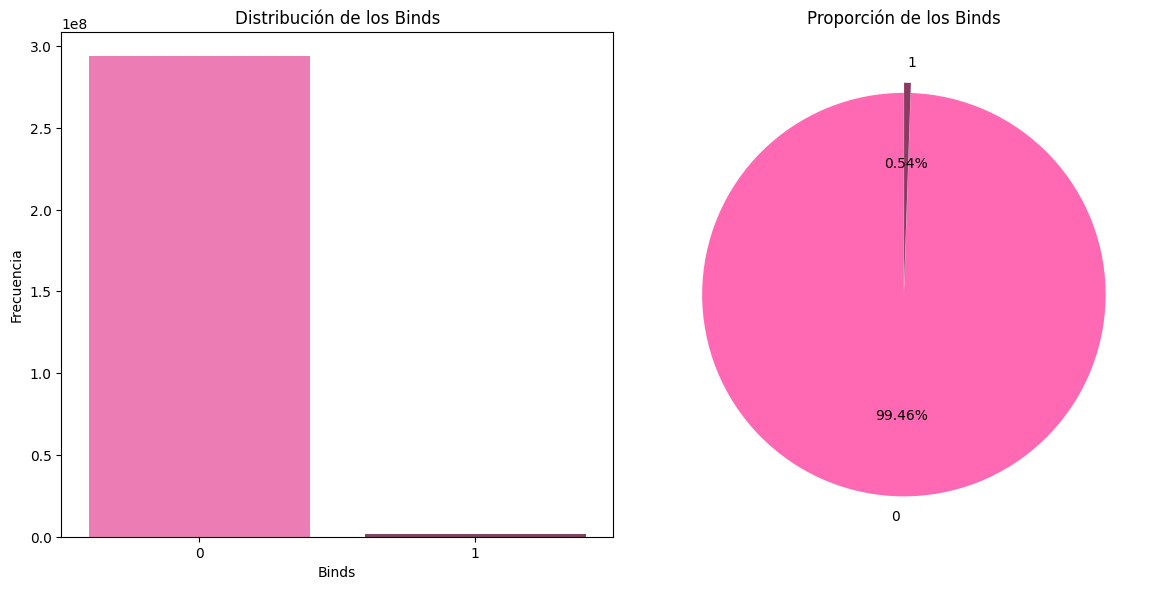

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.countplot(x = data['binds'], hue = data['binds'], palette = ['#FF69B4', '#8B3A62'], legend = False, ax=axes[0])
axes[0].set_title('Distribución de los Binds')
axes[0].set_xlabel('Binds')
axes[0].set_ylabel('Frecuencia')

binds_counts.plot(kind = 'pie', autopct = '%1.2f%%', colors = ['#FF69B4', '#8B3A62'], startangle = 90, explode = (0.05, 0), ax = axes[1])
axes[1].set_title('Proporción de los Binds')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()



In [ ]:
data_copy = data.copy()

En efecto, al ver dos tipos de gráficos para la representación de esta variable, notamos que hay una gran diferencia entre los dos grupos. La clase **0**, que indica que la molécula no se une a la proteína, representa la mayoría de los datos, mientras que la clase **1**, que indica que sí hay unión, es una pequeña parte del total.


## **Datos faltantes**

En esta parte se realiza un análisis para identificar la cantidad de datos faltantes en cada columna de la base de datos. Se utiliza la librería `missingno` para generar una visualización en forma de barra que muestra el porcentaje de datos faltantes en cada columna, ordenados de manera ascendente.

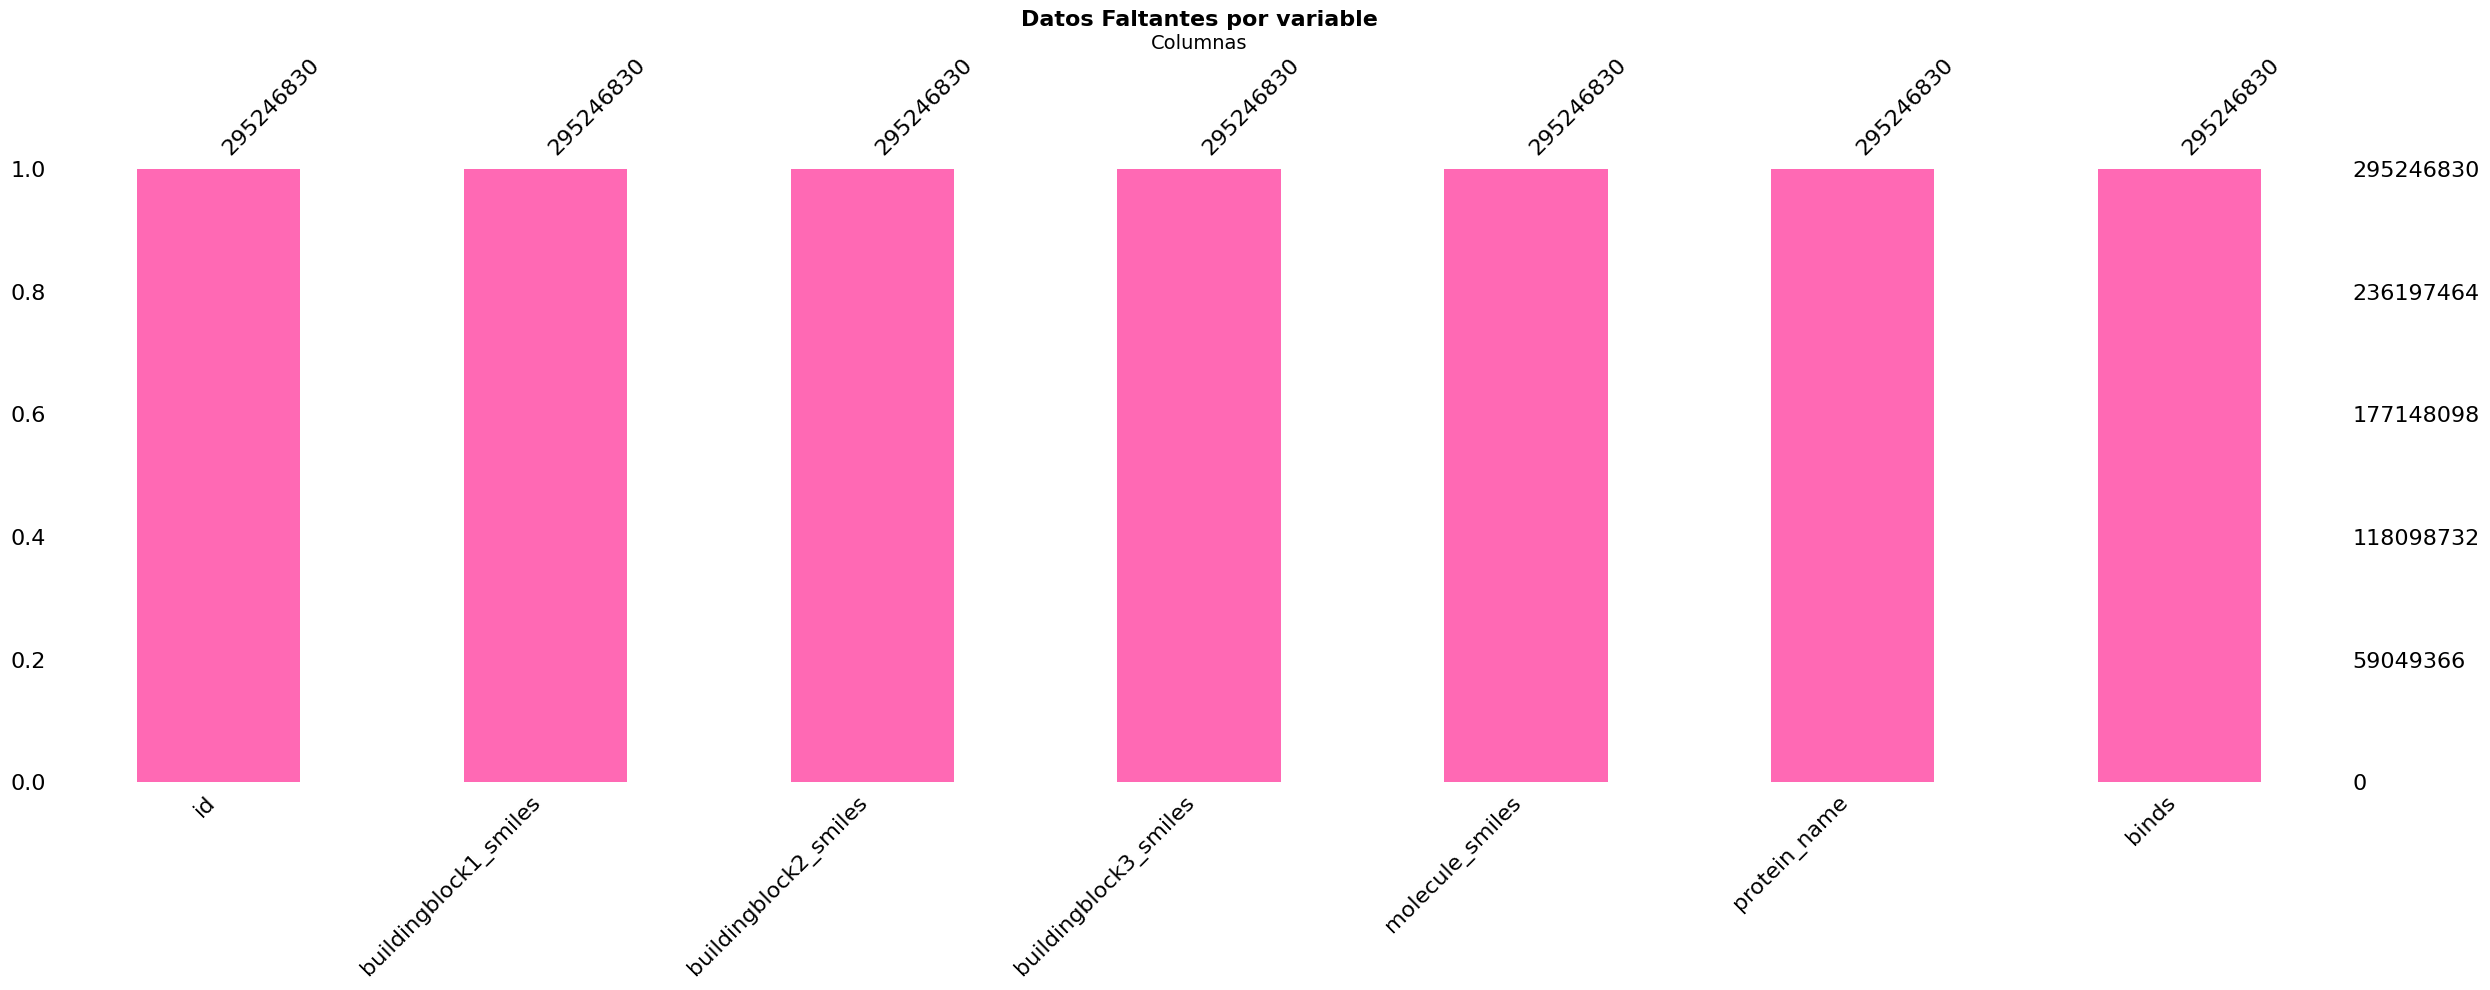

In [ ]:
msno.bar(data, color = "#FF69B4", sort = 'ascending')
plt.title('Datos Faltantes por variable', fontsize = 16, fontweight = 'bold')
plt.xlabel('Columnas', fontsize = 14)
plt.ylabel('Porcentaje de Datos Faltantes', fontsize = 14)
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

El gráfico muestra que no hay datos faltantes en ninguna de las variables (`Id`, `buildingblock1_smiles`, `buildingblock2_smiles` etc.), ya que todas las barras está llenas. Esto indica que las columnas están completas y no presentan valores nulos o faltantes, lo cual es bueno para predecir de manera más precisa nuestro modelo.

## **Filtración de la base de datos por proteínas**

Dada la alta cantidad de datos existentes en la base de datos y la complejidad computacional que esta requiere para realizar los diferentes tipos de modelación y transformación de datos, en esta sección se filtrará la base de datos por el tipo de proteína y a su vez se usarán solo 50.000 observaciones, las cuales son seleccionadas de manera estratificada para no perder el balance que hay en cada clase.

Inicialmente comenzamos agrupando los nombres de los tres tipos de proteínas y contando los valores que existen en cada una de ellas para ver si son aglutinantes a las moléculas o no (0: No se une, 1: Se unen). Luego se muestran en forma de proporción

In [ ]:
proteinas = data.groupby('protein_name')['binds'].value_counts(normalize=True).unstack().reset_index()
proteinas

binds,protein_name,0,1
0,BRD4,0.995357,0.004643
1,HSA,0.995850,0.004150
2,sEH,0.992638,0.007362


Nótese que en todas las proteínas, la mayor proporción se encuentra en la categoría 0, con valores cercanos a 0.99, mientras que la categoría 1 tiene valores mucho más pequeños. Esto puede indicar un desbalance en el momento de aplicar los modelos. Por último, es posible afirmar que de los tres tipos de proteína la que se encuentra menos desbalanceada es `sEH`, dado que la diferencia entre las proporciones de las categorías 0 (0.992638) y 1 (0.007362) es ligeramente menor en comparación con las otras proteínas, lo que indica una distribución un poco más balanceada.

Ahora se generan tres nuevas bases de datos, cada una filtrada por un tipo de proteína específico. A cada conjunto de datos se le aplicará un análisis separado para determinar cuál modelo se desempeña mejor con cada tipo de proteína. Este enfoque permite comparar los resultados y evaluar cuál proteína responde mejor a los diferentes modelos de clasificación.

In [ ]:
data_proteina1 = data[data['protein_name'] == 'sEH']
data_proteina2 = data[data['protein_name'] == 'BRD4']
data_proteina3 = data[data['protein_name'] == 'HSA']

### **Proteína SEH (EPHX2)**

En esta parte del código, se realiza una división del conjunto de datos de la proteína `sEH` utilizando `train_test_split`. El objetivo es extraer una muestra de 100,000 filas para entrenar el modelo, manteniendo la misma proporción de la variable objetivo `binds`. Se utiliza `stratify` para asegurar que la distribución de las clases en `binds` se mantenga balanceada.

In [ ]:
data_p1, _ = train_test_split( data_proteina1, train_size = 100000,  stratify = data_proteina1['binds'],  random_state = 11)

Ahora, se observan los primeros registros del nuevo conjunto de datos (`data_p1`)y se analizan las características de las columnas categóricas, verificando la frecuencia de valores únicos y asegurando que no haya valores nulos.

In [ ]:
data_p1.head()

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds
147239129,147239129,O=C(Nc1c(Cl)cccc1C(=O)O)OCC1c2ccccc2-c2ccccc21,CNC(=O)COCCN.Cl,CN(CCN)C1CCOCC1,CNC(=O)COCCNc1nc(NCCN(C)C2CCOCC2)nc(Nc2c(Cl)cc...,sEH,0
257990426,257990426,O=C(O)C[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)c1c...,Nc1cc(N2CCNCC2)ccc1[N+](=O)[O-],Cl.NCCN1CCCS1(=O)=O,O=C(C[C@@H](Nc1nc(NCCN2CCCS2(=O)=O)nc(Nc2cc(N3...,sEH,0
180571076,180571076,O=C(Nc1ccc(Br)c(C(=O)O)c1)OCC1c2ccccc2-c2ccccc21,NCc1ccc2[nH]ccc2c1,Cc1ccc(N)nn1,Cc1ccc(Nc2nc(NCc3ccc4[nH]ccc4c3)nc(Nc3ccc(Br)c...,sEH,0
186946937,186946937,O=C(Nc1ccc(C(=O)O)c([N+](=O)[O-])c1)OCC1c2cccc...,Cl.NCc1ccc(-c2c[nH]c(=O)[nH]c2=O)cc1,Nc1ccsc1.O=C(O)C(=O)O,O=C(N[Dy])c1ccc(Nc2nc(NCc3ccc(-c4c[nH]c(=O)[nH...,sEH,0
207543668,207543668,O=C(Nc1cccc(-c2cccc(C(=O)O)c2)c1O)OCC1c2ccccc2...,Cl.NCC(=O)N1CCCO1,Nc1c(O)ncnc1O,O=C(N[Dy])c1cccc(-c2cccc(Nc3nc(NCC(=O)N4CCCO4)...,sEH,0


In [ ]:
data_p1.describe(include = object)

,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name
count,100000,100000,100000,100000,100000
unique,271,693,867,100000,1
top,O=C(Nc1cc(C(=O)O)ccc1Br)OCC1c2ccccc2-c2ccccc21,CC1(CCCCN)OCCO1,CSc1nnc(CN)s1,Cc1cc(Nc2nc(Nc3ccc(C)c(Br)c3)nc(Nc3ccc([N+](=O...,sEH
freq,418,261,226,1,100000


In [ ]:
data_p1.isnull().sum()

,0
id,0
buildingblock1_smiles,0
buildingblock2_smiles,0
buildingblock3_smiles,0
molecule_smiles,0
protein_name,0
binds,0


No hay valores faltantes en el conjunto de datos. Lo cual es lo esperado, dado que en la base de datos original no habian datos filtrados. Por lo tanto, es buen indicio de que se hizo bien la filtración de los datos

Se cuenta la cantidad de ocurrencias de las clases en la variable binds para observar si hay un desbalance de clases.

In [ ]:
bind1 = data_p1['binds'].value_counts()
bind1

,count
binds,
0,99264
1,736


In [ ]:
binds1 = data_p1['binds'].value_counts(normalize = True)
binds1

,proportion
binds,
0,0.99264
1,0.00736


Existe un fuerte desbalance en la variable objetivo `binds`, donde la clase **0** domina con un **99.26%** de los datos.

Viendolo gráficamente:

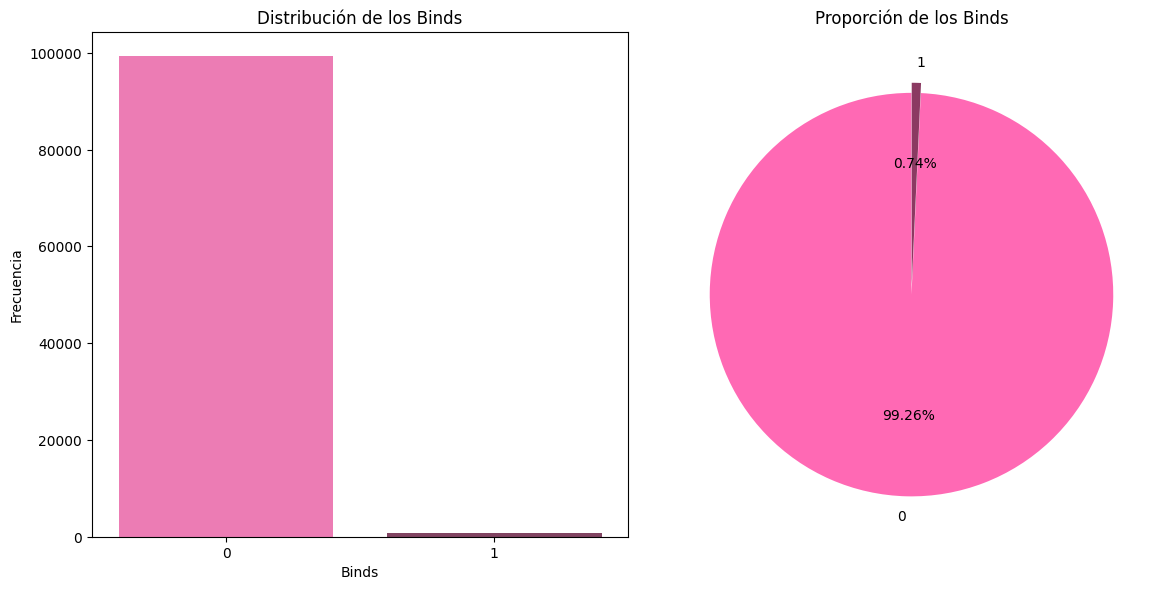

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.countplot(x = data_p1['binds'], hue = data_p1['binds'], palette = ['#FF69B4', '#8B3A62'], legend = False, ax=axes[0])
axes[0].set_title('Distribución de los Binds')
axes[0].set_xlabel('Binds')
axes[0].set_ylabel('Frecuencia')

binds1.plot(kind = 'pie', autopct = '%1.2f%%', colors = ['#FF69B4', '#8B3A62'], startangle = 90, explode = (0.05, 0), ax = axes[1])
axes[1].set_title('Proporción de los Binds')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

 Se visualiza el desbalance de clases de manera clara, donde la clase **0** es mucho más frecuente que la clase **1**

Se utiliza `reset_index()` para reiniciar el índice del DataFrame `data_p1`

In [ ]:
data_p1 = data_p1.reset_index()

En esta parte se seleccionan las columnas categóricas (`protein_name`, `buildingblock1_smiles`, `buildingblock2_smiles`, `buildingblock3_smiles`) que contienen cadenas de texto, y se transforman en variables numéricas utilizando `OneHotEncoder`.

La codificación convierte estas columnas en variables binarias (0 o 1), donde cada valor único en una columna categórica se convierte en una nueva columna.

Finalmente, las nuevas columnas codificadas se añaden al DataFrame original y se eliminan las columnas categóricas originales.

In [ ]:
categoricas = ['protein_name', 'buildingblock1_smiles', 'buildingblock2_smiles', 'buildingblock3_smiles']
encoder1 = OneHotEncoder(sparse_output = False)  #La salida será una matriz densa (DataFrame de Pandas)
encoded1 = encoder1.fit_transform(data_p1[categoricas])
df_encoded1 = pd.DataFrame(encoded1, columns = encoder1.get_feature_names_out(categoricas))
df_proteina1 = pd.concat([data_p1, df_encoded1], axis = 1) # axis = 1: Indica que las columnas especificadas deben ser eliminadas
df_proteina1 = df_proteina1.drop(categoricas, axis = 1)

In [ ]:
df_proteina1.head()

,index,id,molecule_smiles,binds,protein_name_sEH,buildingblock1_smiles_C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_C#CC[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_C#CC[C@@](C)(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_C#CC[C@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_C#CC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,...,buildingblock3_smiles_Nc1ncnc(=O)[nH]1,buildingblock3_smiles_Nc1ncnc(Cl)c1Cl,buildingblock3_smiles_Nc1ncnc2[nH]cnc12,buildingblock3_smiles_Nc1ncnc2[nH]ncc12,buildingblock3_smiles_Nc1ncnc2c1ncn2C1CCCCO1,buildingblock3_smiles_Nc1ncncc1Br,buildingblock3_smiles_Nc1nnc(S)s1,buildingblock3_smiles_Nc1nncs1,buildingblock3_smiles_Nc1nnn[nH]1,buildingblock3_smiles_Nc1noc2ccc(F)cc12
0,147239129,147239129,CNC(=O)COCCNc1nc(NCCN(C)C2CCOCC2)nc(Nc2c(Cl)cc...,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,257990426,257990426,O=C(C[C@@H](Nc1nc(NCCN2CCCS2(=O)=O)nc(Nc2cc(N3...,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,180571076,180571076,Cc1ccc(Nc2nc(NCc3ccc4[nH]ccc4c3)nc(Nc3ccc(Br)c...,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,186946937,186946937,O=C(N[Dy])c1ccc(Nc2nc(NCc3ccc(-c4c[nH]c(=O)[nH...,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,207543668,207543668,O=C(N[Dy])c1cccc(-c2cccc(Nc3nc(NCC(=O)N4CCCO4)...,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Las variables categóricas han sido correctamente transformadas en variables binarias (0 y 1).

In [ ]:
df_proteina1.shape

(100000, 1836)

Luego de haber codificado las variables categóricas, la base de datos cuenta con **100.000** filas y **1836** columnas

Verifiquemos que no se hayan generado datos faltantes con la codificación de las variables categóricas.

In [ ]:
missing_columns1 = df_proteina1.isnull().sum()
missing_columns1= missing_columns1[missing_columns1 > 0]
print(f"Número de columnas con datos faltantes: {len(missing_columns1)}")

Número de columnas con datos faltantes: 0


En efecto, no hay datos faltantes.


En esta parte del código se eliminan las columnas `molecule_smiles` e `id`. Estas columnas no son necesarias para el modelo, ya que no aportan información relevante para la clasificación. La columna `molecule_smiles` es una cadena compleja que no es sencilla de codificar, dado la cantidad de registros únicos que esta variable presenta. Además, esta columna es una construcción de los tres bloques que ya fueron codificados, por lo que no aporta nueva información. Por otro lado, las columna `id` e `index` es simplemente un identificador de las observaciones y no tienen valor predictivo.

In [ ]:
df_proteina1.drop(columns = ['molecule_smiles'], inplace = True)
df_proteina1.drop(columns = ['id'], inplace = True)
df_proteina1.drop(columns = ['index'], inplace = True)

En esta parte del código, se lleva a cabo la selección de características y la definición de la variable objetivo

Se aplica SelectKBest con la función de chi-cuadrado (chi2) para seleccionar las 100 mejores características que tienen una relación más fuerte con la variable objetivo. Este proceso selecciona solo aquellas características que son más relevantes para la clasificación.

In [ ]:
y1 = df_proteina1['binds']

# Aplicar SelectKBest con chi2 para seleccionar las mejores características
k_best1 = SelectKBest(score_func = chi2, k = 100)  # Se quieren conservar k = 100 mejores características
X_new1 = k_best1.fit_transform(df_proteina1, y1)

selected_features = k_best1.get_support(indices=True)  # Obtener los índices de las características seleccionadas
proteina1 = df_proteina1.iloc[:, selected_features]

In [ ]:
# Definir y1 como la variable objetivo (la columna 'binds') en el conjunto de entrenamiento y_train
ytrain = y1.copy()

In [ ]:
proteina1.head()

,binds,buildingblock1_smiles_O=C(NC(Cc1ccccc1)C(=O)O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_O=C(NCC1CCC(C(=O)O)CC1)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_O=C(NC[C@H]1CC[C@H](C(=O)O)CC1)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_O=C(N[C@@H](Cc1cccnc1)C(=O)O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_O=C(N[C@H](Cc1ccc(F)c(F)c1)C(=O)O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_O=C(Nc1ccc(C(=O)O)cc1)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_O=C(Nc1ccc(C(=O)O)cc1O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_O=C(Nc1ccc(C(=O)O)nc1)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_O=C(Nc1cnccc1C(=O)O)OCC1c2ccccc2-c2ccccc21,...,buildingblock3_smiles_Nc1c2c(cc3c1CCC3)CCC2,buildingblock3_smiles_Nc1cc(C(F)(F)F)cc(C(F)(F)F)c1,buildingblock3_smiles_Nc1cc(Cl)ccc1F,buildingblock3_smiles_Nc1cc(F)c(F)cc1[N+](=O)[O-],buildingblock3_smiles_Nc1ccc2c(c1)CNCC2,buildingblock3_smiles_Nc1cccc2ocnc12,buildingblock3_smiles_Nc1cncc(F)c1,buildingblock3_smiles_Nc1n[nH]c2ccc([N+](=O)[O-])cc12,buildingblock3_smiles_Nc1nc(NCc2ccc(F)cc2)ccc1[N+](=O)[O-],buildingblock3_smiles_Nc1ncco1
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
proteina1.shape

(100000, 100)

Finalmente, la base de datos `proteina1` esta lista para ser usada en los diferentes modelos de clasificación. Esta base de datos cuenta con **100.000** filas y **100** columnas

### **Proteína BRD4**

En esta parte del código, se realiza una división del conjunto de datos de la proteína `BRD4` utilizando `train_test_split`. El objetivo es extraer una muestra de 100,000 filas para entrenar el modelo, manteniendo la misma proporción de la variable objetivo `binds`. Se utiliza `stratify` para asegurar que la distribución de las clases en `binds` se mantenga balanceada.

In [ ]:
data_p2, _ = train_test_split( data_proteina2, train_size = 100000,  stratify = data_proteina2['binds'],  random_state = 11)

Ahora, se observan los primeros registros del nuevo conjunto de datos (`data_p2`)y se analizan las características de las columnas categóricas, verificando la frecuencia de valores únicos y asegurando que no haya valores nulos.

In [ ]:
data_p2.head()

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds
100174431,100174431,O=C(N[C@@H](Cc1ccc(F)cc1F)C(=O)O)OCC1c2ccccc2-...,Nc1nc(-c2cccnc2)cs1,Cc1nnsc1CN,Cc1nnsc1CNc1nc(Nc2nc(-c3cccnc3)cs2)nc(N[C@@H](...,BRD4,0
288634638,288634638,O=C(O)[C@H]1CC2CCCCC2N1C(=O)OCC1c2ccccc2-c2ccc...,Nc1ccncc1[N+](=O)[O-],Nc1nc2nc[nH]c2c(=O)[nH]1,O=C(N[Dy])[C@H]1CC2CCCCC2N1c1nc(Nc2nc3nc[nH]c3...,BRD4,0
43808760,43808760,C[C@@H](OCc1ccccc1)[C@H](NC(=O)OCC1c2ccccc2-c2...,COc1c(F)cc(N)cc1F,Nc1ccc(F)cc1CO,COc1c(F)cc(Nc2nc(Nc3ccc(F)cc3CO)nc(N[C@H](C(=O...,BRD4,0
91037118,91037118,O=C(N[C@@H](Cc1c(F)c(F)c(F)c(F)c1F)C(=O)O)OCC1...,Cl.NCCOC1CCS(=O)(=O)C1,Cl.Cl.NCCc1nnc2c(=O)[nH]ccn12,O=C(N[Dy])[C@H](Cc1c(F)c(F)c(F)c(F)c1F)Nc1nc(N...,BRD4,0
3471777,3471777,C#CC[C@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,COC(=O)c1scnc1N,NCC1CSCCN1Cc1ccccc1,C#CC[C@H](CC(=O)N[Dy])Nc1nc(NCC2CSCCN2Cc2ccccc...,BRD4,0


In [ ]:
data_p2.describe(include = object)

,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name
count,100000,100000,100000,100000,100000
unique,271,693,871,100000,1
top,O=C(N[C@@H](Cc1cc(F)c(F)c(F)c1)C(=O)O)OCC1c2cc...,NCCC(=O)NC1CCCC1,Cc1cc2cc(CN)ccc2[nH]1,Cc1ccc(C)c(CNc2nc(NCC3CCN(C(N)=O)C3)nc(Nc3ccc(...,BRD4
freq,436,272,233,1,100000


In [ ]:
data_p2.isnull().sum()

,0
id,0
buildingblock1_smiles,0
buildingblock2_smiles,0
buildingblock3_smiles,0
molecule_smiles,0
protein_name,0
binds,0


No hay valores faltantes en el conjunto de datos. Lo cual es lo esperado, dado que en la base de datos original no habian datos filtrados. Por lo tanto, es buen indicio de que se hizo bien la filtración de los datos

Se cuenta la cantidad de ocurrencias de las clases en la variable binds para observar si hay un desbalance de clases.

In [ ]:
bind2 = data_p2['binds'].value_counts()
bind2

,count
binds,
0,99536
1,464


In [ ]:
binds2 = data_p2['binds'].value_counts(normalize = True)
binds2

,proportion
binds,
0,0.99536
1,0.00464


Existe un fuerte desbalance en la variable objetivo `binds`, donde la clase **0** domina con un **99.54%** de los datos.

Viendolo gráficamente:

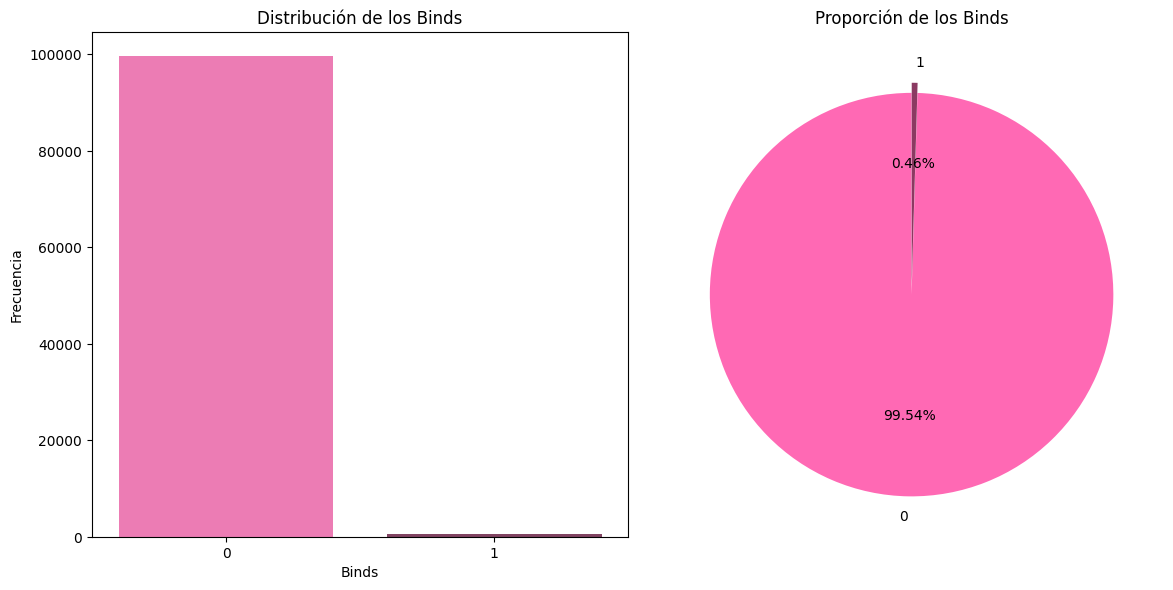

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.countplot(x = data_p2['binds'], hue = data_p2['binds'], palette = ['#FF69B4', '#8B3A62'], legend = False, ax=axes[0])
axes[0].set_title('Distribución de los Binds')
axes[0].set_xlabel('Binds')
axes[0].set_ylabel('Frecuencia')

binds2.plot(kind = 'pie', autopct = '%1.2f%%', colors = ['#FF69B4', '#8B3A62'], startangle = 90, explode = (0.05, 0), ax = axes[1])
axes[1].set_title('Proporción de los Binds')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

 Se visualiza el desbalance de clases de manera clara, donde la clase **0** es mucho más frecuente que la clase **1**

Se utiliza `reset_index()` para reiniciar el índice del DataFrame `data_p2`

In [ ]:
data_p2 = data_p2.reset_index()

En esta parte se seleccionan las columnas categóricas (`protein_name`, `buildingblock1_smiles`, `buildingblock2_smiles`, `buildingblock3_smiles`) que contienen cadenas de texto, y se transforman en variables numéricas utilizando `OneHotEncoder`.

La codificación convierte estas columnas en variables binarias (0 o 1), donde cada valor único en una columna categórica se convierte en una nueva columna.

Finalmente, las nuevas columnas codificadas se añaden al DataFrame original y se eliminan las columnas categóricas originales.

In [ ]:
categoricas = ['protein_name', 'buildingblock1_smiles', 'buildingblock2_smiles', 'buildingblock3_smiles']
encoder2 = OneHotEncoder(sparse_output = False)
encoded2 = encoder2.fit_transform(data_p2[categoricas])
df_encoded2 = pd.DataFrame(encoded2, columns = encoder2.get_feature_names_out(categoricas))
df_proteina2 = pd.concat([data_p2, df_encoded2], axis = 1)
df_proteina2 = df_proteina2.drop(categoricas, axis = 1)

In [ ]:
df_proteina2.head()

,index,id,molecule_smiles,binds,protein_name_BRD4,buildingblock1_smiles_C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_C#CC[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_C#CC[C@@](C)(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_C#CC[C@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_C#CC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,...,buildingblock3_smiles_Nc1ncnc(=O)[nH]1,buildingblock3_smiles_Nc1ncnc(Cl)c1Cl,buildingblock3_smiles_Nc1ncnc2[nH]cnc12,buildingblock3_smiles_Nc1ncnc2[nH]ncc12,buildingblock3_smiles_Nc1ncnc2c1ncn2C1CCCCO1,buildingblock3_smiles_Nc1ncncc1Br,buildingblock3_smiles_Nc1nnc(S)s1,buildingblock3_smiles_Nc1nncs1,buildingblock3_smiles_Nc1nnn[nH]1,buildingblock3_smiles_Nc1noc2ccc(F)cc12
0,100174431,100174431,Cc1nnsc1CNc1nc(Nc2nc(-c3cccnc3)cs2)nc(N[C@@H](...,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,288634638,288634638,O=C(N[Dy])[C@H]1CC2CCCCC2N1c1nc(Nc2nc3nc[nH]c3...,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,43808760,43808760,COc1c(F)cc(Nc2nc(Nc3ccc(F)cc3CO)nc(N[C@H](C(=O...,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,91037118,91037118,O=C(N[Dy])[C@H](Cc1c(F)c(F)c(F)c(F)c1F)Nc1nc(N...,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3471777,3471777,C#CC[C@H](CC(=O)N[Dy])Nc1nc(NCC2CSCCN2Cc2ccccc...,0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Las variables categóricas han sido correctamente transformadas en variables binarias (0 y 1).

In [ ]:
df_proteina2.shape

(100000, 1840)

Luego de haber codificado las variables categóricas, la base de datos cuenta con **100.000** filas y **1840** columnas

Verifiquemos que no se hayan generado datos faltantes con la codificación de las variables categóricas.

In [ ]:
missing_columns2 = df_proteina2.isnull().sum()
missing_columns2 = missing_columns2[missing_columns2 > 0]
print(f"Número de columnas con datos faltantes: {len(missing_columns2)}")

Número de columnas con datos faltantes: 0


En efecto, no hay datos faltantes.


En esta parte del código se eliminan las columnas `molecule_smiles` e `id`. Estas columnas no son necesarias para el modelo, ya que no aportan información relevante para la clasificación. La columna `molecule_smiles` es una cadena compleja que no es sencilla de codificar, dado la cantidad de registros únicos que esta variable presenta. Además, esta columna es una construcción de los tres bloques que ya fueron codificados, por lo que no aporta nueva información. Por otro lado, las columna `id` e `index` es simplemente un identificador de las observaciones y no tienen valor predictivo.

In [ ]:
df_proteina2.drop(columns = ['molecule_smiles'], inplace = True)
df_proteina2.drop(columns = ['id'], inplace = True)
df_proteina2.drop(columns = ['index'], inplace = True)

En esta parte del código, se lleva a cabo la selección de características y la definición de la variable objetivo

Se aplica SelectKBest con la función de chi-cuadrado (chi2) para seleccionar las 100 mejores características que tienen una relación más fuerte con la variable objetivo. Este proceso selecciona solo aquellas características que son más relevantes para la clasificación.

In [ ]:
y2 = df_proteina2['binds']
k_best2 = SelectKBest(score_func = chi2, k = 100)
X_new2 = k_best2.fit_transform(df_proteina2, y2)

selected_features = k_best2.get_support(indices=True)
proteina2 = df_proteina2.iloc[:, selected_features]

In [ ]:
ytrain2 = y2.copy()

In [ ]:
proteina2.head()

,binds,buildingblock1_smiles_CC(C)(C)OC(=O)CCC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_CC(C)(C)OCC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_CC(C)CC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_CC(OC(C)(C)C)C(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_Cc1ccccc1[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_N#Cc1ccc(C[C@@H](NC(=O)OCC2c3ccccc3-c3ccccc32)C(=O)O)cc1,buildingblock1_smiles_O=C(NC(CC1CCCCC1)C(=O)O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_O=C(NC(CCc1ccccc1)C(=O)O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_O=C(NC(Cc1ccccc1)C(=O)O)OCC1c2ccccc2-c2ccccc21,...,buildingblock3_smiles_Nc1cc(Cl)c(O)c(Cl)c1,buildingblock3_smiles_Nc1cc(N2CCNCC2)ccc1[N+](=O)[O-],buildingblock3_smiles_Nc1ccc2[nH]ncc2c1,buildingblock3_smiles_Nc1ccc2c(c1)CCC2=O,buildingblock3_smiles_Nc1ccc2c(c1)CNC2=O,buildingblock3_smiles_Nc1ccc2c(c1)COC2=O,buildingblock3_smiles_Nc1cccnc1F,buildingblock3_smiles_Nc1nc2ccccc2s1,buildingblock3_smiles_Nc1nc2nc[nH]c2c(=O)[nH]1,buildingblock3_smiles_Nc1nccs1
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
proteina2.shape

(100000, 100)

Finalmente, la base de datos `proteina2` esta lista para ser usada en los diferentes modelos de clasificación. Esta base de datos cuenta con **100.000** filas y **100** columnas

### **Proteína HSA (ALBA)**

En esta parte del código, se realiza una división del conjunto de datos de la proteína `HSA` utilizando `train_test_split`. El objetivo es extraer una muestra de 100,000 filas para entrenar el modelo, manteniendo la misma proporción de la variable objetivo `binds`. Se utiliza `stratify` para asegurar que la distribución de las clases en `binds` se mantenga balanceada.

In [ ]:
data_p3, _ = train_test_split( data_proteina3, train_size = 100000,  stratify = data_proteina3['binds'],  random_state = 11)

Ahora, se observan los primeros registros del nuevo conjunto de datos (`data_p3`)y se analizan las características de las columnas categóricas, verificando la frecuencia de valores únicos y asegurando que no haya valores nulos.

In [ ]:
data_p3.head()

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds
79451005,79451005,O=C(NC1(C(=O)O)CCCCC1)OCC1c2ccccc2-c2ccccc21,Nc1ccnc(Cl)c1,N#Cc1cccc(N)n1,N#Cc1cccc(Nc2nc(Nc3ccnc(Cl)c3)nc(NC3(C(=O)N[Dy...,HSA,0
251510695,251510695,O=C(O)C[C@@H](Cc1ccc([N+](=O)[O-])cc1)NC(=O)OC...,Nc1ccc(O)cn1,Cn1ncc2cc(N)ccc21,Cn1ncc2cc(Nc3nc(Nc4ccc(O)cn4)nc(N[C@@H](CC(=O)...,HSA,0
50733376,50733376,Cc1cc(C(=O)O)ccc1NC(=O)OCC1c2ccccc2-c2ccccc21,Cl.NCCOC1CCS(=O)(=O)C1,Cn1nnc(N)n1,Cc1cc(C(=O)N[Dy])ccc1Nc1nc(NCCOC2CCS(=O)(=O)C2...,HSA,0
62661181,62661181,Cn1cc(C[C@@H](NC(=O)OCC2c3ccccc3-c3ccccc32)C(=...,Cl.NCC1CC(C(N)=O)=NO1,Nc1ccc(F)c(C(F)(F)F)c1,Cn1cc(C[C@@H](Nc2nc(NCC3CC(C(N)=O)=NO3)nc(Nc3c...,HSA,0
266507149,266507149,O=C(O)C[C@H](Cc1ccc(C(F)(F)F)cc1)NC(=O)OCC1c2c...,Cl.Nc1ccc(O)cc1Cl,Cc1ccnc(N)c1,Cc1ccnc(Nc2nc(Nc3ccc(O)cc3Cl)nc(N[C@H](CC(=O)N...,HSA,0


In [ ]:
data_p3.describe(include = object)

,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name
count,100000,100000,100000,100000,100000
unique,271,693,871,100000,1
top,O=C(Nc1cc(Br)cc(C(=O)O)c1)OCC1c2ccccc2-c2ccccc21,NCc1c(F)cccc1N1CCCC1,Cc1nc(Cl)c(N)c(Cl)n1,COc1ccncc1CNc1nc(Nc2cnc(C)cn2)nc(N2CCC[C@H]2C(...,HSA
freq,435,281,224,1,100000


In [ ]:
data_p3.isnull().sum()

,0
id,0
buildingblock1_smiles,0
buildingblock2_smiles,0
buildingblock3_smiles,0
molecule_smiles,0
protein_name,0
binds,0


No hay valores faltantes en el conjunto de datos. Lo cual es lo esperado, dado que en la base de datos original no habian datos filtrados. Por lo tanto, es buen indicio de que se hizo bien la filtración de los datos

Se cuenta la cantidad de ocurrencias de las clases en la variable binds para observar si hay un desbalance de clases.

In [ ]:
bind3 = data_p3['binds'].value_counts()
bind3

,count
binds,
0,99585
1,415


In [ ]:
binds3 = data_p3['binds'].value_counts(normalize = True)
binds3

,proportion
binds,
0,0.99585
1,0.00415


Existe un fuerte desbalance en la variable objetivo `binds`, donde la clase **0** domina con un **99.6%** de los datos.

Viendolo gráficamente:

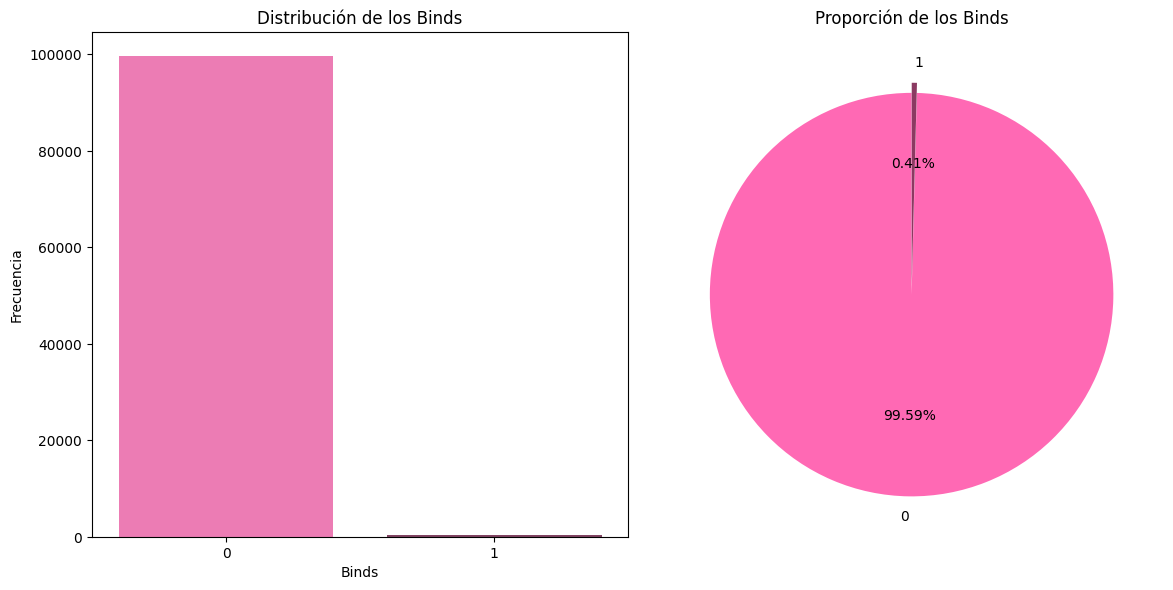

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.countplot(x = data_p3['binds'], hue = data_p3['binds'], palette = ['#FF69B4', '#8B3A62'], legend = False, ax=axes[0])
axes[0].set_title('Distribución de los Binds')
axes[0].set_xlabel('Binds')
axes[0].set_ylabel('Frecuencia')

binds3.plot(kind = 'pie', autopct = '%1.2f%%', colors = ['#FF69B4', '#8B3A62'], startangle = 90, explode = (0.05, 0), ax = axes[1])
axes[1].set_title('Proporción de los Binds')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

 Se visualiza el desbalance de clases de manera clara, donde la clase **0** es mucho más frecuente que la clase **1**

Se utiliza `reset_index()` para reiniciar el índice del DataFrame `data_p2`

In [ ]:
data_p3 = data_p3.reset_index()

En esta parte se seleccionan las columnas categóricas (`protein_name`, `buildingblock1_smiles`, `buildingblock2_smiles`, `buildingblock3_smiles`) que contienen cadenas de texto, y se transforman en variables numéricas utilizando `OneHotEncoder`.

La codificación convierte estas columnas en variables binarias (0 o 1), donde cada valor único en una columna categórica se convierte en una nueva columna.

Finalmente, las nuevas columnas codificadas se añaden al DataFrame original y se eliminan las columnas categóricas originales.

In [ ]:
categoricas = ['protein_name', 'buildingblock1_smiles', 'buildingblock2_smiles', 'buildingblock3_smiles']
encoder3 = OneHotEncoder(sparse_output = False)
encoded3 = encoder3.fit_transform(data_p3[categoricas])
df_encoded3 = pd.DataFrame(encoded3, columns = encoder3.get_feature_names_out(categoricas))
df_proteina3 = pd.concat([data_p3, df_encoded3], axis = 1)
df_proteina3 = df_proteina3.drop(categoricas, axis = 1)

In [ ]:
df_proteina3.head()

,index,id,molecule_smiles,binds,protein_name_HSA,buildingblock1_smiles_C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_C#CC[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_C#CC[C@@](C)(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_C#CC[C@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_C#CC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,...,buildingblock3_smiles_Nc1ncnc(=O)[nH]1,buildingblock3_smiles_Nc1ncnc(Cl)c1Cl,buildingblock3_smiles_Nc1ncnc2[nH]cnc12,buildingblock3_smiles_Nc1ncnc2[nH]ncc12,buildingblock3_smiles_Nc1ncnc2c1ncn2C1CCCCO1,buildingblock3_smiles_Nc1ncncc1Br,buildingblock3_smiles_Nc1nnc(S)s1,buildingblock3_smiles_Nc1nncs1,buildingblock3_smiles_Nc1nnn[nH]1,buildingblock3_smiles_Nc1noc2ccc(F)cc12
0,79451005,79451005,N#Cc1cccc(Nc2nc(Nc3ccnc(Cl)c3)nc(NC3(C(=O)N[Dy...,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,251510695,251510695,Cn1ncc2cc(Nc3nc(Nc4ccc(O)cn4)nc(N[C@@H](CC(=O)...,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,50733376,50733376,Cc1cc(C(=O)N[Dy])ccc1Nc1nc(NCCOC2CCS(=O)(=O)C2...,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,62661181,62661181,Cn1cc(C[C@@H](Nc2nc(NCC3CC(C(N)=O)=NO3)nc(Nc3c...,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,266507149,266507149,Cc1ccnc(Nc2nc(Nc3ccc(O)cc3Cl)nc(N[C@H](CC(=O)N...,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Las variables categóricas han sido correctamente transformadas en variables binarias (0 y 1).

In [ ]:
df_proteina3.shape

(100000, 1840)

Luego de haber codificado las variables categóricas, la base de datos cuenta con **100.000** filas y **1840** columnas

Verifiquemos que no se hayan generado datos faltantes con la codificación de las variables categóricas.

In [ ]:
missing_columns3 = df_proteina3.isnull().sum()
missing_columns3 = missing_columns3[missing_columns3 > 0]
print(f"Número de columnas con datos faltantes: {len(missing_columns3)}")

Número de columnas con datos faltantes: 0


En efecto, no hay datos faltantes.


En esta parte del código se eliminan las columnas `molecule_smiles` e `id`. Estas columnas no son necesarias para el modelo, ya que no aportan información relevante para la clasificación. La columna `molecule_smiles` es una cadena compleja que no es sencilla de codificar, dado la cantidad de registros únicos que esta variable presenta. Además, esta columna es una construcción de los tres bloques que ya fueron codificados, por lo que no aporta nueva información. Por otro lado, las columna `id` e `index` es simplemente un identificador de las observaciones y no tienen valor predictivo.

En esta parte del código, se lleva a cabo la selección de características y la definición de la variable objetivo

In [ ]:
df_proteina3.drop(columns = ['molecule_smiles'], inplace = True)
df_proteina3.drop(columns = ['id'], inplace = True)
df_proteina3.drop(columns = ['index'], inplace = True)

Se aplica SelectKBest con la función de chi-cuadrado (chi2) para seleccionar las 100 mejores características que tienen una relación más fuerte con la variable objetivo. Este proceso selecciona solo aquellas características que son más relevantes para la clasificación.

In [ ]:
y3 = df_proteina3['binds']

# Aplicar SelectKBest con chi2 para seleccionar las mejores características
k_best3 = SelectKBest(score_func = chi2, k = 100)  # Se quieren conservar k = 100 mejores características
X_new3 = k_best3.fit_transform(df_proteina3, y3)

selected_features = k_best3.get_support(indices=True)  # Obtener los índices de las características seleccionadas
proteina3 = df_proteina3.iloc[:, selected_features]

In [ ]:
# Definir y3 como la variable objetivo (la columna 'binds') en el conjunto de entrenamiento y_train
ytrain = y3.copy()

In [ ]:
proteina3.head()

,binds,buildingblock1_smiles_CC(C)(C)OC(=O)CCC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_CC(OC(C)(C)C)C(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_Cc1cc(Cl)cc(C(=O)O)c1NC(=O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_Cc1ccc(C(=O)O)cc1NC(=O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_O=C(NC(CC1CCCCC1)C(=O)O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_O=C(NC(Cc1ccccc1)C(=O)O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_O=C(N[C@@H](Cc1cccnc1)C(=O)O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_O=C(N[C@H](Cc1ccc(-c2ccccc2)cc1)C(=O)O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_O=C(Nc1cc(C(=O)O)cc(C(=O)O)c1)OCC1c2ccccc2-c2ccccc21,...,buildingblock3_smiles_Nc1cccc2ocnc12,buildingblock3_smiles_Nc1cn[nH]c1,buildingblock3_smiles_Nc1cncc(F)c1,buildingblock3_smiles_Nc1n[nH]c2cc(F)ccc12,buildingblock3_smiles_Nc1nc(Cl)c2[nH]cnc2n1,buildingblock3_smiles_Nc1nc2c(s1)CN(C(=O)OCc1ccccc1)CC2,buildingblock3_smiles_Nc1nc[nH]n1,buildingblock3_smiles_Nc1ncnc(Cl)c1Cl,buildingblock3_smiles_Nc1nncs1,buildingblock3_smiles_Nc1nnn[nH]1
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
proteina3.shape

(100000, 100)

Finalmente, la base de datos `proteina3` esta lista para ser usada en los diferentes modelos de clasificación. Esta base de datos cuenta con **100.000** filas y **100** columnas

# **Base de datos (Test)**


In [81]:
data_prueba = pd.read_parquet('test.parquet', engine = 'pyarrow')

## **Características de la base de datos**

In [ ]:
data_prueba.head()

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name
0,295246830,C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,C=Cc1ccc(N)cc1,C=Cc1ccc(N)cc1,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ccc(C=C...,BRD4
1,295246831,C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,C=Cc1ccc(N)cc1,C=Cc1ccc(N)cc1,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ccc(C=C...,HSA
2,295246832,C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,C=Cc1ccc(N)cc1,C=Cc1ccc(N)cc1,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ccc(C=C...,sEH
3,295246833,C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,C=Cc1ccc(N)cc1,CC(O)Cn1cnc2c(N)ncnc21,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ncnc3c2...,BRD4
4,295246834,C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,C=Cc1ccc(N)cc1,CC(O)Cn1cnc2c(N)ncnc21,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ncnc3c2...,HSA


In [ ]:
data_prueba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1674896 entries, 0 to 1674895
Data columns (total 6 columns):
 #   Column                 Non-Null Count    Dtype 
---  ------                 --------------    ----- 
 0   id                     1674896 non-null  int64 
 1   buildingblock1_smiles  1674896 non-null  object
 2   buildingblock2_smiles  1674896 non-null  object
 3   buildingblock3_smiles  1674896 non-null  object
 4   molecule_smiles        1674896 non-null  object
 5   protein_name           1674896 non-null  object
dtypes: int64(1), object(5)
memory usage: 76.7+ MB


In [ ]:
data_prueba.shape

(1674896, 6)

In [ ]:
data_prueba.describe(include = object)

,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name
count,1674896,1674896,1674896,1674896,1674896
unique,341,1140,1389,878022,3
top,O=C(N[C@@H]1CCN(c2cc(C(=O)O)cc(Cl)n2)C1)OCC1c2...,Nc1nc(NCc2ccc(F)cc2)ccc1[N+](=O)[O-],Cl.Cl.NCCc1nnc2c(=O)[nH]ccn12,[N-]=[N+]=NCCC[C@H](Nc1nc(NCc2cccs2)nc(Nc2noc3...,BRD4
freq,14098,14637,10323,3,558859


In [ ]:
dataprueba_copy = data_prueba.copy()

## **Datos faltantes**

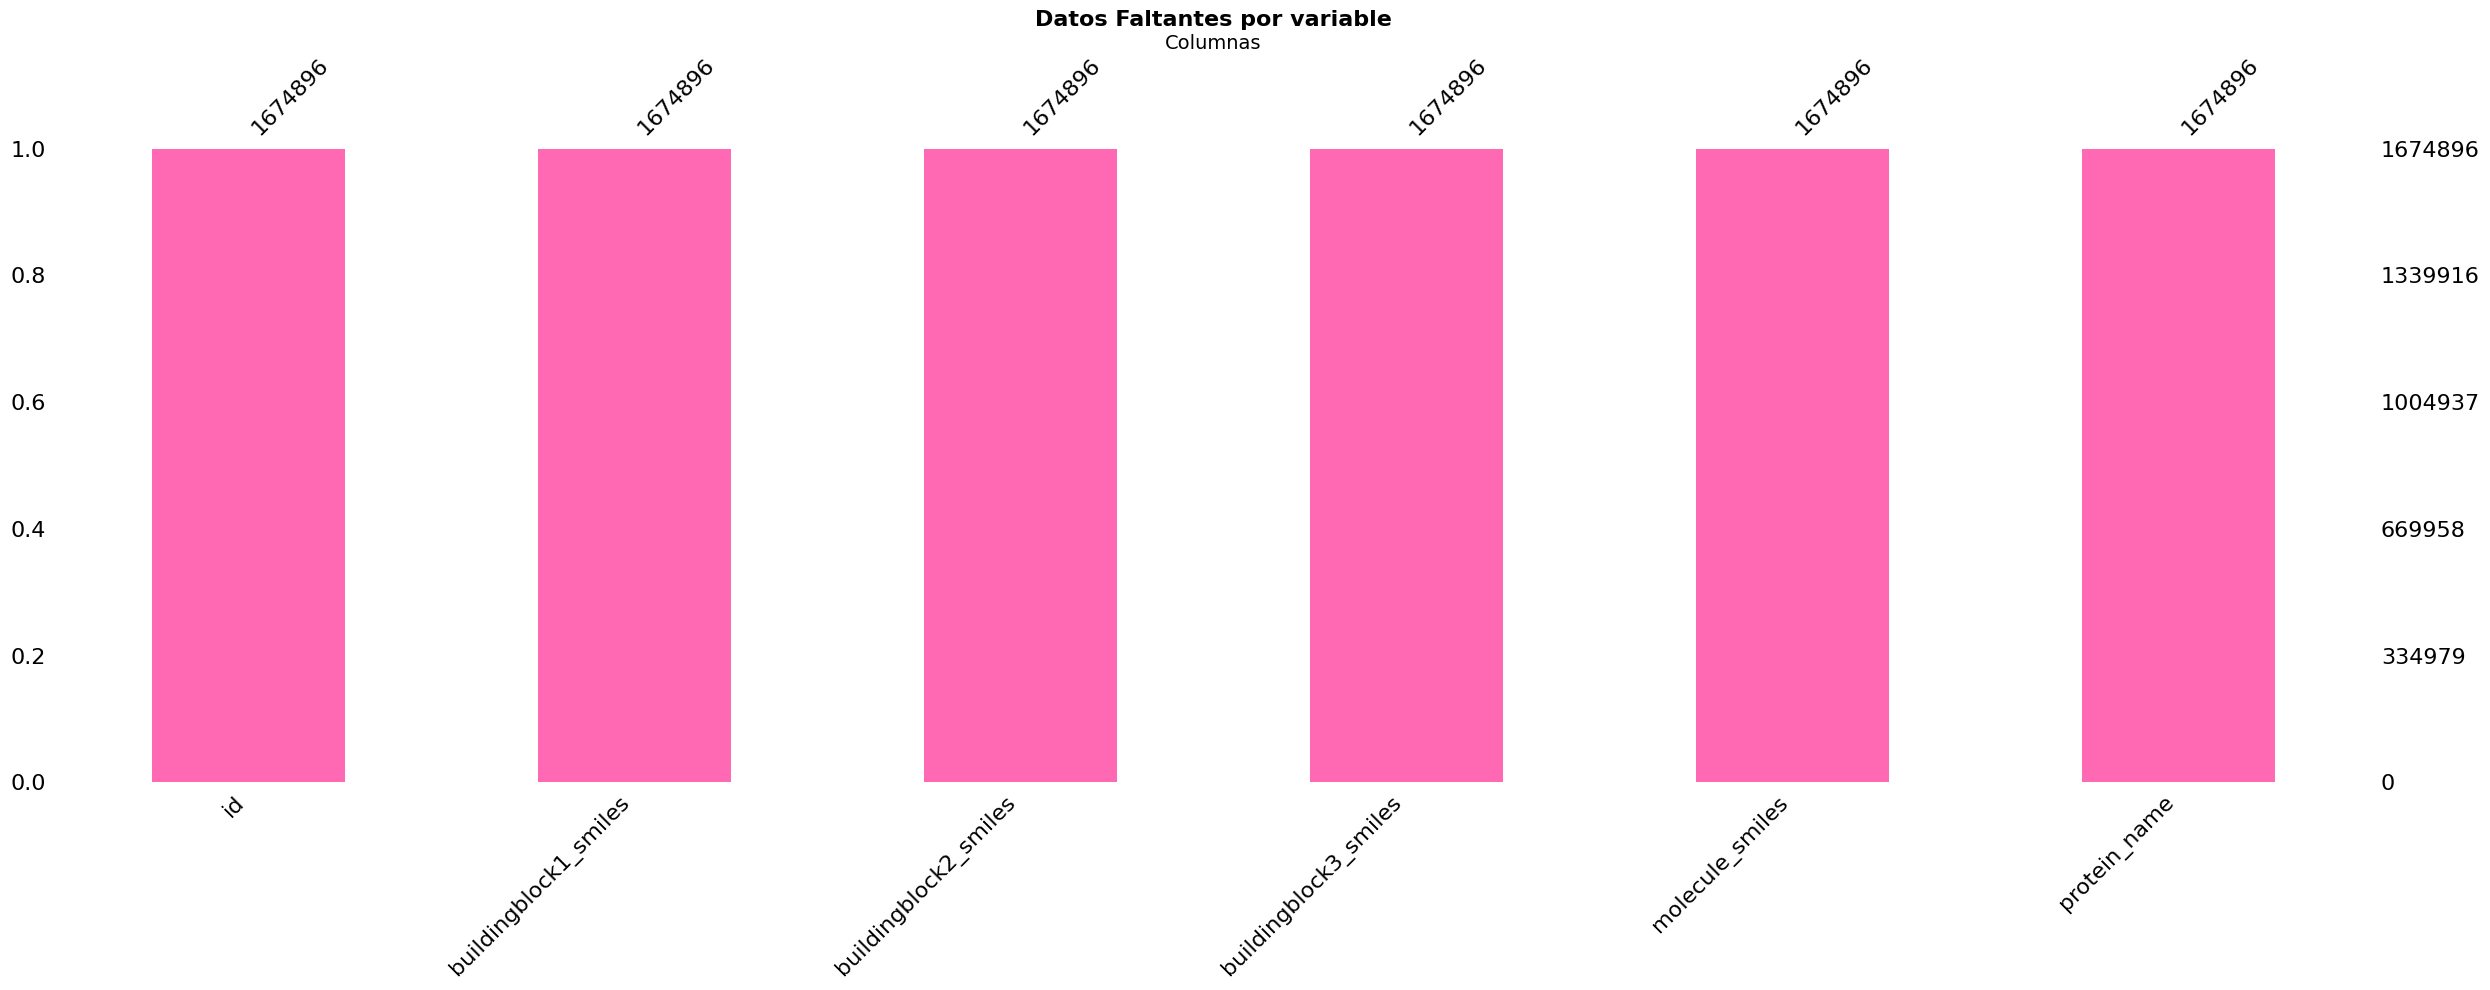

In [ ]:
msno.bar(data_prueba, color = "#FF69B4", sort = 'ascending')
plt.title('Datos Faltantes por variable', fontsize = 16, fontweight = 'bold')
plt.xlabel('Columnas', fontsize = 14)
plt.ylabel('Porcentaje de Datos Faltantes', fontsize = 14)
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

## **Filtración de la base de datos por proteínas**

In [82]:
dp_proteina1 = data_prueba[data_prueba['protein_name'] == 'sEH']
dp_proteina2 = data_prueba[data_prueba['protein_name'] == 'BRD4']
dp_proteina3 = data_prueba[data_prueba['protein_name'] == 'HSA']

### **Proteína SEH (EPHX2)**

In [83]:
dp_proteina1.head()

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name
2,295246832,C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,C=Cc1ccc(N)cc1,C=Cc1ccc(N)cc1,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ccc(C=C...,sEH
5,295246835,C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,C=Cc1ccc(N)cc1,CC(O)Cn1cnc2c(N)ncnc21,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ncnc3c2...,sEH
8,295246838,C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,C=Cc1ccc(N)cc1,CC1(C)CCCC1(O)CN,C#CCCC[C@H](Nc1nc(NCC2(O)CCCC2(C)C)nc(Nc2ccc(C...,sEH
11,295246841,C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,C=Cc1ccc(N)cc1,COC(=O)c1cc(Cl)sc1N,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2sc(Cl)c...,sEH
14,295246844,C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,C=Cc1ccc(N)cc1,CSC1CCC(CN)CC1,C#CCCC[C@H](Nc1nc(NCC2CCC(SC)CC2)nc(Nc2ccc(C=C...,sEH


In [84]:
dp_proteina1.describe(include = object)

,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name
count,558142,558142,558142,558142,558142
unique,341,1140,1389,558142,1
top,CC(C)(C)OC(=O)N1C[C@H](Oc2ccccc2I)C[C@@H]1C(=O)O,Nc1nc(NCc2ccc(F)cc2)ccc1[N+](=O)[O-],Cl.Cl.NCCc1nnc2c(=O)[nH]ccn12,[N-]=[N+]=NCCC[C@H](Nc1nc(NCc2cccs2)nc(Nc2noc3...,sEH
freq,4800,4879,3441,1,558142


In [85]:
dp_proteina1.isnull().sum()

,0
id,0
buildingblock1_smiles,0
buildingblock2_smiles,0
buildingblock3_smiles,0
molecule_smiles,0
protein_name,0


In [86]:
dp_proteina1 = dp_proteina1.reset_index()

In [95]:
categoricas = ['protein_name', 'buildingblock1_smiles', 'buildingblock2_smiles', 'buildingblock3_smiles']
p_encoder1 = OneHotEncoder(sparse_output = False)
p_encoded1 = p_encoder1.fit_transform(dp_proteina1[categoricas])
p_df_encoded1 = pd.DataFrame(p_encoded1, columns = p_encoder1.get_feature_names_out(categoricas))
p_df_proteina1 = pd.concat([dp_proteina1, p_df_encoded1], axis = 1)
p_df_proteina1 = p_df_proteina1.drop(categoricas, axis = 1)

In [97]:
p_df_proteina1.head()

,index,id,molecule_smiles,protein_name_sEH,buildingblock1_smiles_C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_C#CC[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_C#CC[C@@](C)(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_C#CC[C@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_C#CC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,...,buildingblock3_smiles_O=C(O)c1nccc(N2CCOCC2)n1,buildingblock3_smiles_O=C(O)c1nccnc1N1CCCCC1,buildingblock3_smiles_O=C(O)c1ncn(-c2ccccc2)n1,buildingblock3_smiles_O=C(O)c1ncsc1C(F)(F)F,buildingblock3_smiles_O=C(O)c1scc2c1CCCC2,buildingblock3_smiles_O=C1CC(C(=O)O)c2cccnc2N1,buildingblock3_smiles_O=C1CC2(C1)CC(C(=O)O)C2,buildingblock3_smiles_O=C1CCC(C(=O)O)CC1,buildingblock3_smiles_O=C1NC(=O)C2(CCC(C(=O)O)CC2)N1,buildingblock3_smiles_O=C1NCC(Cn2cc(C(=O)O)nn2)O1
0,2,295246832,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ccc(C=C...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5,295246835,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ncnc3c2...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8,295246838,C#CCCC[C@H](Nc1nc(NCC2(O)CCCC2(C)C)nc(Nc2ccc(C...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11,295246841,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2sc(Cl)c...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,14,295246844,C#CCCC[C@H](Nc1nc(NCC2CCC(SC)CC2)nc(Nc2ccc(C=C...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [98]:
p_df_proteina1.shape

(558142, 2874)

In [99]:
missing_columns1p = p_df_proteina1.isnull().sum()
missing_columns1p = missing_columns1p[missing_columns1p > 0]
print(f"Número de columnas con datos faltantes: {len(missing_columns1p)}")

Número de columnas con datos faltantes: 0


In [100]:
p_df_proteina1.drop(columns = ['molecule_smiles'], inplace = True)
p_df_proteina1.drop(columns = ['id'], inplace = True)
p_df_proteina1.drop(columns = ['index'], inplace = True)

In [94]:
p_df_proteina1.head()

,protein_name_sEH,buildingblock1_smiles_C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_C#CC[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_C#CC[C@@](C)(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_C#CC[C@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_C#CC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_C=CCC(CC=C)(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_C=CCC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_C=CCC[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,...,buildingblock3_smiles_O=C(O)c1nccc(N2CCOCC2)n1,buildingblock3_smiles_O=C(O)c1nccnc1N1CCCCC1,buildingblock3_smiles_O=C(O)c1ncn(-c2ccccc2)n1,buildingblock3_smiles_O=C(O)c1ncsc1C(F)(F)F,buildingblock3_smiles_O=C(O)c1scc2c1CCCC2,buildingblock3_smiles_O=C1CC(C(=O)O)c2cccnc2N1,buildingblock3_smiles_O=C1CC2(C1)CC(C(=O)O)C2,buildingblock3_smiles_O=C1CCC(C(=O)O)CC1,buildingblock3_smiles_O=C1NC(=O)C2(CCC(C(=O)O)CC2)N1,buildingblock3_smiles_O=C1NCC(Cn2cc(C(=O)O)nn2)O1
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [101]:
p_df_proteina1.shape

(558142, 2871)

### **Proteína BRD4**

In [102]:
dp_proteina2.head()

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name
0,295246830,C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,C=Cc1ccc(N)cc1,C=Cc1ccc(N)cc1,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ccc(C=C...,BRD4
3,295246833,C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,C=Cc1ccc(N)cc1,CC(O)Cn1cnc2c(N)ncnc21,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ncnc3c2...,BRD4
6,295246836,C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,C=Cc1ccc(N)cc1,CC1(C)CCCC1(O)CN,C#CCCC[C@H](Nc1nc(NCC2(O)CCCC2(C)C)nc(Nc2ccc(C...,BRD4
9,295246839,C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,C=Cc1ccc(N)cc1,COC(=O)c1cc(Cl)sc1N,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2sc(Cl)c...,BRD4
12,295246842,C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,C=Cc1ccc(N)cc1,CSC1CCC(CN)CC1,C#CCCC[C@H](Nc1nc(NCC2CCC(SC)CC2)nc(Nc2ccc(C=C...,BRD4


In [103]:
dp_proteina2.describe(include = object)

,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name
count,558859,558859,558859,558859,558859
unique,341,1140,1389,558859,1
top,O=C(O)[C@@H]1C=C(c2ccc(Br)nc2)CN1C(=O)OCC1c2cc...,Nc1nc(NCc2ccc(F)cc2)ccc1[N+](=O)[O-],Cl.Cl.NCCc1nnc2c(=O)[nH]ccn12,[N-]=[N+]=NCCC[C@H](Nc1nc(NCc2cccs2)nc(Nc2noc3...,BRD4
freq,4809,4879,3441,1,558859


In [104]:
dp_proteina2.isnull().sum()

,0
id,0
buildingblock1_smiles,0
buildingblock2_smiles,0
buildingblock3_smiles,0
molecule_smiles,0
protein_name,0


In [105]:
dp_proteina2 = dp_proteina2.reset_index()

In [106]:
categoricas = ['protein_name', 'buildingblock1_smiles', 'buildingblock2_smiles', 'buildingblock3_smiles']
p_encoder2 = OneHotEncoder(sparse_output = False)
p_encoded2 = p_encoder2.fit_transform(dp_proteina2[categoricas])
p_df_encoded2 = pd.DataFrame(p_encoded2, columns = p_encoder2.get_feature_names_out(categoricas))
p_df_proteina2 = pd.concat([dp_proteina2, p_df_encoded2], axis = 1)
p_df_proteina2 = p_df_proteina2.drop(categoricas, axis = 1)

In [107]:
p_df_proteina2.head()

,index,id,molecule_smiles,protein_name_BRD4,buildingblock1_smiles_C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_C#CC[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_C#CC[C@@](C)(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_C#CC[C@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_C#CC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,...,buildingblock3_smiles_O=C(O)c1nccc(N2CCOCC2)n1,buildingblock3_smiles_O=C(O)c1nccnc1N1CCCCC1,buildingblock3_smiles_O=C(O)c1ncn(-c2ccccc2)n1,buildingblock3_smiles_O=C(O)c1ncsc1C(F)(F)F,buildingblock3_smiles_O=C(O)c1scc2c1CCCC2,buildingblock3_smiles_O=C1CC(C(=O)O)c2cccnc2N1,buildingblock3_smiles_O=C1CC2(C1)CC(C(=O)O)C2,buildingblock3_smiles_O=C1CCC(C(=O)O)CC1,buildingblock3_smiles_O=C1NC(=O)C2(CCC(C(=O)O)CC2)N1,buildingblock3_smiles_O=C1NCC(Cn2cc(C(=O)O)nn2)O1
0,0,295246830,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ccc(C=C...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3,295246833,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ncnc3c2...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6,295246836,C#CCCC[C@H](Nc1nc(NCC2(O)CCCC2(C)C)nc(Nc2ccc(C...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9,295246839,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2sc(Cl)c...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12,295246842,C#CCCC[C@H](Nc1nc(NCC2CCC(SC)CC2)nc(Nc2ccc(C=C...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [108]:
p_df_proteina2.shape

(558859, 2874)

In [109]:
missing_columns2p = p_df_proteina2.isnull().sum()
missing_columns2p = missing_columns2p[missing_columns2p > 0]
print(f"Número de columnas con datos faltantes: {len(missing_columns2p)}")

Número de columnas con datos faltantes: 0


In [110]:
p_df_proteina2.drop(columns = ['molecule_smiles'], inplace = True)
p_df_proteina2.drop(columns = ['id'], inplace = True)
p_df_proteina2.drop(columns = ['index'], inplace = True)

In [111]:
p_df_proteina2.head()

,protein_name_BRD4,buildingblock1_smiles_C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_C#CC[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_C#CC[C@@](C)(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_C#CC[C@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_C#CC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_C=CCC(CC=C)(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_C=CCC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_C=CCC[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,...,buildingblock3_smiles_O=C(O)c1nccc(N2CCOCC2)n1,buildingblock3_smiles_O=C(O)c1nccnc1N1CCCCC1,buildingblock3_smiles_O=C(O)c1ncn(-c2ccccc2)n1,buildingblock3_smiles_O=C(O)c1ncsc1C(F)(F)F,buildingblock3_smiles_O=C(O)c1scc2c1CCCC2,buildingblock3_smiles_O=C1CC(C(=O)O)c2cccnc2N1,buildingblock3_smiles_O=C1CC2(C1)CC(C(=O)O)C2,buildingblock3_smiles_O=C1CCC(C(=O)O)CC1,buildingblock3_smiles_O=C1NC(=O)C2(CCC(C(=O)O)CC2)N1,buildingblock3_smiles_O=C1NCC(Cn2cc(C(=O)O)nn2)O1
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [112]:
p_df_proteina2.shape

(558859, 2871)

### **Proteína HSA (ALBA)**

In [113]:
dp_proteina3.head()

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name
1,295246831,C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,C=Cc1ccc(N)cc1,C=Cc1ccc(N)cc1,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ccc(C=C...,HSA
4,295246834,C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,C=Cc1ccc(N)cc1,CC(O)Cn1cnc2c(N)ncnc21,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ncnc3c2...,HSA
7,295246837,C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,C=Cc1ccc(N)cc1,CC1(C)CCCC1(O)CN,C#CCCC[C@H](Nc1nc(NCC2(O)CCCC2(C)C)nc(Nc2ccc(C...,HSA
10,295246840,C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,C=Cc1ccc(N)cc1,COC(=O)c1cc(Cl)sc1N,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2sc(Cl)c...,HSA
13,295246843,C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,C=Cc1ccc(N)cc1,CSC1CCC(CN)CC1,C#CCCC[C@H](Nc1nc(NCC2CCC(SC)CC2)nc(Nc2ccc(C=C...,HSA


In [114]:
dp_proteina3.describe(include = object)

,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name
count,557895,557895,557895,557895,557895
unique,341,1140,1389,557895,1
top,CC(C)(C)OC(=O)N1C[C@@H](n2cncc2Br)C[C@H]1C(=O)O,Nc1nc(NCc2ccc(F)cc2)ccc1[N+](=O)[O-],Cl.Cl.NCCc1nnc2c(=O)[nH]ccn12,[N-]=[N+]=NCCC[C@H](Nc1nc(NCc2cccs2)nc(Nc2noc3...,HSA
freq,4744,4879,3441,1,557895


In [115]:
dp_proteina3.isnull().sum()

,0
id,0
buildingblock1_smiles,0
buildingblock2_smiles,0
buildingblock3_smiles,0
molecule_smiles,0
protein_name,0


In [116]:
dp_proteina3 = dp_proteina3.reset_index()

In [117]:
categoricas = ['protein_name', 'buildingblock1_smiles', 'buildingblock2_smiles', 'buildingblock3_smiles']
p_encoder3 = OneHotEncoder(sparse_output = False)
p_encoded3 = p_encoder3.fit_transform(dp_proteina3[categoricas])
p_df_encoded3 = pd.DataFrame(p_encoded3, columns = p_encoder3.get_feature_names_out(categoricas))
p_df_proteina3 = pd.concat([dp_proteina3, p_df_encoded3], axis = 1)
p_df_proteina3 = p_df_proteina3.drop(categoricas, axis = 1)

In [118]:
p_df_proteina3.head()

,index,id,molecule_smiles,protein_name_HSA,buildingblock1_smiles_C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_C#CC[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_C#CC[C@@](C)(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_C#CC[C@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_C#CC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,...,buildingblock3_smiles_O=C(O)c1nccc(N2CCOCC2)n1,buildingblock3_smiles_O=C(O)c1nccnc1N1CCCCC1,buildingblock3_smiles_O=C(O)c1ncn(-c2ccccc2)n1,buildingblock3_smiles_O=C(O)c1ncsc1C(F)(F)F,buildingblock3_smiles_O=C(O)c1scc2c1CCCC2,buildingblock3_smiles_O=C1CC(C(=O)O)c2cccnc2N1,buildingblock3_smiles_O=C1CC2(C1)CC(C(=O)O)C2,buildingblock3_smiles_O=C1CCC(C(=O)O)CC1,buildingblock3_smiles_O=C1NC(=O)C2(CCC(C(=O)O)CC2)N1,buildingblock3_smiles_O=C1NCC(Cn2cc(C(=O)O)nn2)O1
0,1,295246831,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ccc(C=C...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4,295246834,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ncnc3c2...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7,295246837,C#CCCC[C@H](Nc1nc(NCC2(O)CCCC2(C)C)nc(Nc2ccc(C...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10,295246840,C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2sc(Cl)c...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,13,295246843,C#CCCC[C@H](Nc1nc(NCC2CCC(SC)CC2)nc(Nc2ccc(C=C...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [119]:
p_df_proteina3.shape

(557895, 2874)

In [120]:
missing_columns3p = p_df_proteina3.isnull().sum()
missing_columns3p = missing_columns3p[missing_columns3p > 0]
print(f"Número de columnas con datos faltantes: {len(missing_columns3p)}")

Número de columnas con datos faltantes: 0


In [121]:
p_df_proteina3.drop(columns = ['molecule_smiles'], inplace = True)
p_df_proteina3.drop(columns = ['id'], inplace = True)
p_df_proteina3.drop(columns = ['index'], inplace = True)

In [122]:
p_df_proteina3.head()

,protein_name_HSA,buildingblock1_smiles_C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_C#CC[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_C#CC[C@@](C)(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_C#CC[C@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,buildingblock1_smiles_C#CC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_C=CCC(CC=C)(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_C=CCC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,buildingblock1_smiles_C=CCC[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,...,buildingblock3_smiles_O=C(O)c1nccc(N2CCOCC2)n1,buildingblock3_smiles_O=C(O)c1nccnc1N1CCCCC1,buildingblock3_smiles_O=C(O)c1ncn(-c2ccccc2)n1,buildingblock3_smiles_O=C(O)c1ncsc1C(F)(F)F,buildingblock3_smiles_O=C(O)c1scc2c1CCCC2,buildingblock3_smiles_O=C1CC(C(=O)O)c2cccnc2N1,buildingblock3_smiles_O=C1CC2(C1)CC(C(=O)O)C2,buildingblock3_smiles_O=C1CCC(C(=O)O)CC1,buildingblock3_smiles_O=C1NC(=O)C2(CCC(C(=O)O)CC2)N1,buildingblock3_smiles_O=C1NCC(Cn2cc(C(=O)O)nn2)O1
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [123]:
p_df_proteina3.shape

(557895, 2871)

# **Ejercicio 2.2: Single-Cell Perturbations**